<a href="https://colab.research.google.com/github/juanlu29/juanlu29/blob/gp_aprendizaje/modeloGausianoLineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias importadas y constantes usadas

In [60]:
# Modulos y constantes

import numpy as np
import random
import scipy
import scipy.linalg
from matplotlib import pyplot as plt
import seaborn as sns

pi = np.pi

# Los siguientes parametros son cuadrados de las desviaciones estandar
sigma_signal_sq = 20.5 # desviación estándar del ruido usado para enmascarar la señal de entrenamiento
sigma_b_sq = 70.5 # En distribucion gaussiana a priori de modelo de regresióón linear, desviación estándar de la ordenada
sigma_m_sq = 1.0 # En distribucion gaussiana a priori de modelo de regresióón linear, desviación estándar de la pendiente

ordenada_real = 10.
pendiente_real = 5.

# Hiperparámetros de los kernels
s = 30.
l = 5.

Informacion sobre la particion del sistema y las realizaciones a realizar

In [62]:
n_r = 4 # numero de realizaciones del proceso gaussiano

n_tp = 500 # puntos para muestrear el fondo continuo para la desviacion estándar

x_bot_b = -2.5
x_top_b = 14.

x = np.linspace(x_bot_b,x_top_b,n_tp)

n_test = 40 # puntos para realizar inferencia

#x_train = np.linspace(x_bot_b,x_top_b,n_test)
#y_train = np.fromiter([ordenada_real+pendiente_real*x+random.gauss(0,np.sqrt(sigma_signal_sq)) for x in x_train],float)
y_train = np.fromiter([60*np.sin(x/3.)+random.gauss(0,np.sqrt(sigma_signal_sq)) for x in x_train],float)

x = np.linspace(-30.,80.,n_tp)


La siguiente celda contiene informacion sobre el conjunto de puntos - objetivos sobre el que entrenar el proceso gausiano, así como una especificación a priori de la matriz de covarianzas

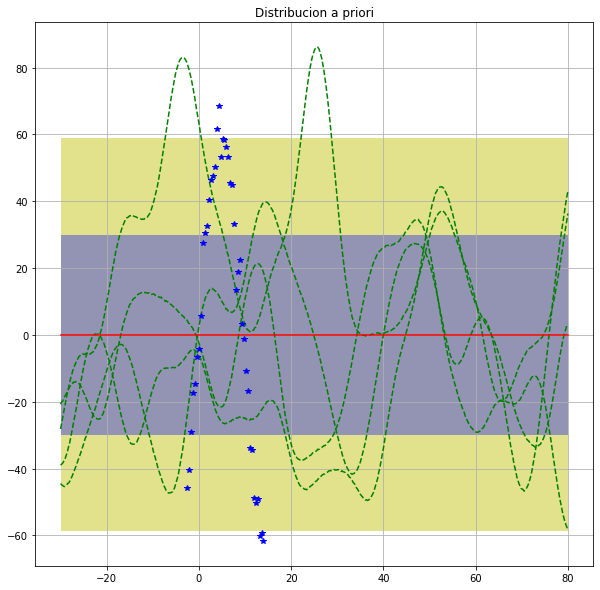

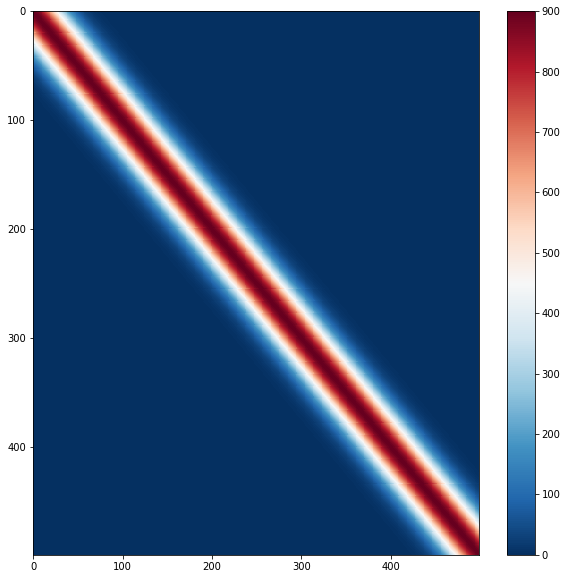

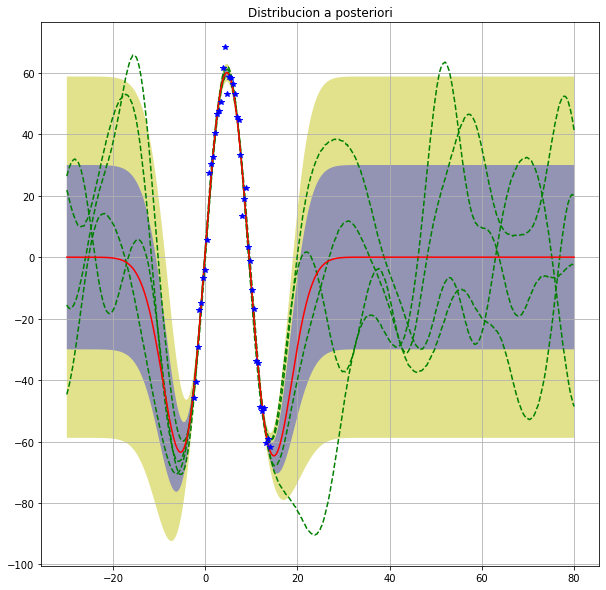

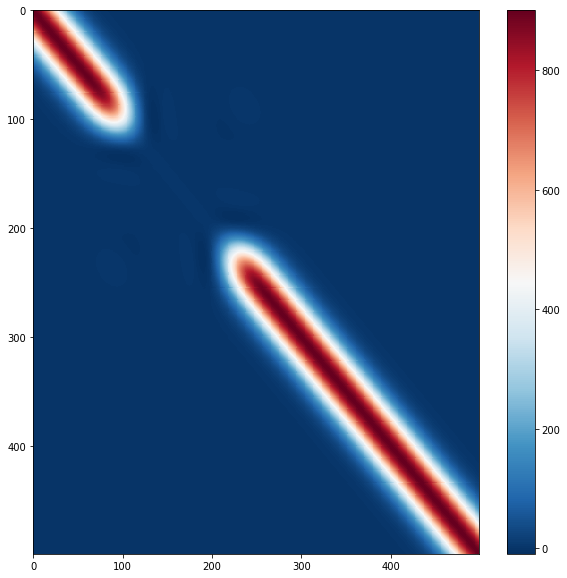

In [77]:

# Hacemos la proyeccion sobre el espacio propio del modelo de regresion linear y derivamos la matriz de dispersion de los parámetros
proyeccionlinear = espacioPropio()
aleatorio = espacioPropio()
corr_crec_dist = espacioPropio()
corr_kec = espacioPropio()
#mCov_x,phi_x,mean = proyeccionlinear.formaBilinealAleatoria(x,sigma_m_sq)
#mCov_train,phi_train,mean_train = proyeccionlinear.formaBilinealAleatoria(x_train,sigma_m_sq)

# Modelo lineal
#K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = proyeccionlinear.linear(x,x_train,sigma_b_sq,sigma_m_sq)
# Kernel aleatorio
#K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = aleatorio.covarianzaAleatoria(x,x_train,sigma_m_sq)
# Kernel correlaciones crecientes con distancia linealmente
#K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = corr_crec_dist.corr_linear_creciente(x,x_train,100.,2.)
# Kernel correlaciones decrecientes inversamente a la distancia
#K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = corr_crec_dist.corr_linear_decreciente(x,x_train,300.,500.)
# Kernel exponencial cuadratico
K_prior,K_train_prior,K_train_train,phi_x,phi_t,mean = corr_kec.kernel_exponencial_cuadratico(x,x_train,s,l)


# Generamos un proceso gausiano para generar la distribucion de funciones con probabilidades a priori (las que nos ofrece las incertidumbres en los parametros)
gp_cov_diag = gaussProcess(K_prior,K_train_prior,K_train_train, np.zeros(n_tp),phi_x)
sigma_prior = gp_cov_diag.sigmaCalc(gp_cov_diag.K_prior)

# Entrenamos con los datos proyectados sobre el espacio propio de esta regresion
gp_cov_diag.entrenarGP(phi_t,y_train,sigma_signal_sq)
sigma_pred = gp_cov_diag.sigmaCalc(gp_cov_diag.K_pred)



visualizacion_prior = datosVisualizacion("Distribucion a priori")
visualizacion_poste = datosVisualizacion("Distribucion a posteriori")

# Predictivo

visualizacion_poste.add_covariance(gp_cov_diag.K_pred)
visualizacion_poste.add_sigma(x,sigma_pred)
visualizacion_poste.add_mean(x,gp_cov_diag.mean_pred)
visualizacion_poste.add_train_data(x_train,y_train)

[visualizacion_poste.add_data(x,gp_cov_diag.distribucionGP(gp_cov_diag.mean_pred,gp_cov_diag.L_pred)[0],inset) for inset in range(n_r) ]
[visualizacion_poste.add_data_plot(inset) for inset in range(n_r) ]

# Prior

visualizacion_prior.add_covariance(gp_cov_diag.K_prior)
visualizacion_prior.add_sigma(x,sigma_prior)
visualizacion_prior.add_mean(x,np.zeros(n_tp))
visualizacion_prior.add_train_data(x_train,y_train)

[visualizacion_prior.add_data(x,gp_cov_diag.distribucionGP(gp_cov_diag.mean_prior,gp_cov_diag.L_prior)[0],inset) for inset in range(n_r) ]
[visualizacion_prior.add_data_plot(inset) for inset in range(n_r) ]

visualizacion_prior.mostrarPlot()
visualizacion_poste.mostrarPlot()
visualizacion_prior.hmapCov()
visualizacion_poste.hmapCov()

Este google colab sera un espacio donde practicar conceptos básicos sobre procesos gausianos, en general desarrollar clases para reproducir los conceptos básicos de estos y practicar alguna regresión "de juguete". Muestrea funciones del espacio F:R¹



In [76]:
class espacioPropio():
  '''
  Esta clase define el espacio propio donde proyectamos y la matriz de covarianza resultante
  '''

  def linear(self,x,x_train, sigma_b,sigma_m):
    '''
    Se interpretan sigma_b y sigma_m como varianzas de distribuciones a priori gaussianas
    para la ordenada en origen y para la pendiente de nuestro modelo linear.
    x es el input
    '''
    phi_x = np.array([np.array([1,xe]) for xe in x])
    phi_t = np.array([np.array([1,xe]) for xe in x_train])
    eps = np.array([[sigma_b,0],[0,sigma_m]])
    K_prior = np.matmul(np.matmul(phi_x,eps),phi_x.T)
    K_pred_train = np.matmul(np.matmul(phi_x,eps),phi_t.T) # Es la matriz de covarianzas entre datos de la distribución a priori y el entrenamiento
    K_train_train = np.matmul(np.matmul(phi_t,eps),phi_t.T) # Es la matriz de covarianzas entre los datos de entrenamiento

    return K_prior,K_pred_train,K_train_train, phi_x, phi_t, np.zeros(x.size)

  def covarianzaProceso(self,phi_x,covM):
    '''
    Devuelve la matriz de covarianza correspondiente a distribucion de probabilidad a priori en base a la incertidumbre de los parametros de una regresion lineal .
    '''
    return np.matmul(np.matmul(phi_x,covM),phi_x.T)

  def covarianzaAleatoria(self,x, x_train,sigma):
    '''
    Genera matriz de covarianza con correlaciones aleatorias sobre el espacio en que realizamos el proceso gaussiano,
    generamos una matriz de la aplicacion aleatoria dada una distribucion normal Sigma ~ normal(0,1)

    Partimos de que a priori, sin condicionar resultados, si tenemos los puntos sobre los que samplear las funciones
    y los de entrenamiento, partimos de que la matriz de covarianza a priori total o global resulta de combinar las siguientes submatrices

                                                  ( M(n_star,n_star), M(n_star,n_train) 
    M(n_star + n_train, n_star + n_train) =    (                                          )
                                                  ( M(n,train,n_star), M(n_train,n_train)

    Que es generada recordando la siguiente propiedad de matrices definidas positivas simétricas

    Cov = M*M_t

    Simplemente debemos generar M y obtener la matriz de covarianza de la anterior forma y las submatrices de covarianza cuando queramos condicionar el procesos gausiano

    Creo que no importa el orden de las coordenadas porque estamos trabajando con algebra lineal (permutaciones de filas dejan la matriz con las mismas propiedades)

    '''

    phi_x = x
    phi_t = x_train
    sqrt_K_total = np.array([[random.gauss(0,0.1) for xi in np.concatenate((x, x_train), axis=None)] for xj in np.concatenate((x, x_train), axis=None)])

    K_total = np.matmul(sqrt_K_total,sqrt_K_total.T) # Definiendola así nos aseguramos que resulte una matriz definida positiva
   
    K_prior = K_total[:x.size,:x.size]
    K_pred_train = K_total[:x.size,x.size:]
    K_train_train = K_total[x.size:,x.size:]

    return K_prior,K_pred_train,K_train_train, phi_x, phi_t, np.zeros(x.size)



  def corr_linear_creciente(self,x, x_train,s,l):
    '''
    Genera matriz de covarianza con correlaciones que aumentan con la separación entre coordenadas
    sigma y l son hiperparámetros de este kernel
    '''

  
    phi_x = x
    phi_t = x_train

    x_domain = np.concatenate((x,x_train), axis =None)

    K_total =  np.array([[(s*np.abs(xj-xi))/l for xi in x_domain] for xj in x_domain]) # Debemos tomar valor absoluto para asegurarnos que la matriz resultante sea simétrica

    #K_total = np.matmul(sqrt_K_total,sqrt_K_total.T) # Definiendola así nos aseguramos que resulte una matriz definida positiva    

    K0, K1, K2 = self.submatrices(K_total, x.size, x_train.size)

    return K0, K1, K2, phi_x, phi_t, np.zeros(x.size)

  def corr_linear_decreciente(self,x, x_train,s,l):
    '''
    Genera matriz de covarianza con correlaciones que disminuyen con la separación entre coordenadas
    sigma y l son hiperparámetros de este kernel

    cor(dx) =   s. / (1 + dx/l)

    '''

  
    phi_x = x
    phi_t = x_train

    x_domain = np.concatenate((x,x_train), axis =None)

    K_total =  np.array([[s/(1.+(np.abs(xj-xi)/l)) for xi in x_domain] for xj in x_domain]) # Debemos tomar valor absoluto para asegurarnos que la matriz resultante sea simétrica

    #K_total = np.matmul(sqrt_K_total,sqrt_K_total.T) # Definiendola así nos aseguramos que resulte una matriz definida positiva    

    K0, K1, K2 = self.submatrices(K_total, x.size, x_train.size)

    return K0, K1, K2, phi_x, phi_t, np.zeros(x.size)


  def kernel_exponencial_cuadratico(self,x, x_train,s,l):
    '''
    Genera matriz de covarianza con correlaciones de acuerdo al kernel exponencial cuadrático

    K(x-x') =   s² exp((-[x-x']²)/2l²)

    '''

    phi_x = x
    phi_t = x_train

    x_domain = np.concatenate((x,x_train), axis =None)

    K_total =  np.array([[np.power(s,2)*np.exp(-np.power(xi-xj,2)/(2.*np.power(l,2)))  for xi in x_domain] for xj in x_domain]) # Debemos tomar valor absoluto para asegurarnos que la matriz resultante sea simétrica

    #K_total = np.matmul(sqrt_K_total,sqrt_K_total.T) # Definiendola así nos aseguramos que resulte una matriz definida positiva    

    K0, K1, K2 = self.submatrices(K_total, x.size, x_train.size)

    return K0, K1, K2, phi_x, phi_t, np.zeros(x.size)

  def submatrices(self,K_total,i,f):
    '''
    Este metodo, dada una matriz de covarianzas del proceso gausiano sin condicionar a las observaciones,
    devuelve las matrices K_prior, K_pred_train, K_train_train que serán usadas para muestrear el proceso
    '''
    Ks = [K_total[:i,:i], K_total[:i,i:], K_total[i:,i:]]
    return Ks[0], Ks[1], Ks[2] #  K_prior, K_pred_train, K_train_train respectivamente



class gaussProcess():
  def __init__(self,K_p,K_p_t,K_t_t,Mean, Input):
    '''
    Los objetos de esta clase modelan procesos gaussianos caracterizados por su promedio y covarianza
    Eps es la matriz de covarianzas de los pesos del proceso gausiano
    '''
    self.x = Input # Dominio de la regresion
    self.K_prior = K_p # Matriz de covarianzas usada para definir la distribucion a priori y mas tarde para muestrear funciones del proceso gausiano
    self.K_pred_train = K_p_t # Es la matriz de covarianzas entre datos de la distribución a priori y el entrenamiento
    self.K_train_train = K_t_t # Es la matriz de covarianzas entre los datos de entrenamiento
    self.mean_prior = Mean
    self.L_prior = self.cholDescomp(self.K_prior)

  def cholDescomp(self,K):
    '''
    Cholesky decomposition
    '''
    try:
      L = scipy.linalg.cholesky(K, lower=True)
    except:
      L = scipy.linalg.cholesky(K + np.diag(0.01*np.ones(int(np.sqrt(K.size)))), lower=True)

    return L


  def entrenarGP(self,entrenamiento_x,entrenamiento_y,noiseLevel):
    '''
    Dados unos datos de entrenamiento, recupera el proceso gaussiano con la distribucion a posteriori condicionando el GP a las observaciones
    noiseLevel es la desviación estándar cuadrática del ruido sobre los puntos del conjunto de datos de entrenamiento
    '''
    self.xtrain = entrenamiento_x
    self.ytrain = entrenamiento_y

    # Definimos nueva covarianza
    # Calculo de matriz inversa de la covarianza. 
    try:
      self.invK = np.linalg.inv(self.K_train_train + noiseLevel*np.diag(np.ones(len(self.xtrain))))
    except:
      print("La matriz inversa no existe porque el determinante es cero")
      
    self.K_pred = self.K_prior - np.matmul(np.matmul(self.K_pred_train,self.invK),self.K_pred_train.T)
    
    self.L_pred = self.cholDescomp(self.K_pred)

    self.mean_pred = np.matmul(np.matmul(self.K_pred_train,self.invK),self.ytrain)


  def distribucionGP(self,mean,L):
    '''
    Genera realizaciones del proceso gaussiano dada la descomposicion cholesky de la matriz de covarianzas y la media correspondiente
    '''
    gaussNumbers = np.fromiter([ random.gauss(0,1) for x in range(len(np.diag(L))) ],float)
    return [mean + np.matmul(L,gaussNumbers.T)]

  def sigmaCalc(self,cov):
    '''
    Desviacion estándar punto a punto del proceso gausiano dado por la matriz de covarianza 
    Es la raiz cuadrado de los elementos de la diagonal de la matriz de covarianzas del proceso generado
    '''
    return np.sqrt(np.diag(cov))

class datosVisualizacion():
  '''
  Esta clase contiene los datos de entrenamiento y realizaciones de los procesos gaussianos para la visualización de los mismos
  '''
  def __init__(self,Titulo):
    self.x = []
    self.y = []
    self.sigma = []
    self.realizacion_dict = {}
    self.titulo = Titulo
    self.inicializacionPlot()

  def inicializacionPlot(self):
    '''
    Inicializa el objeto matplotlib
    '''
    self.fig,self.ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    self.ax.set_title(self.titulo)
    self.fig_hm, self.ax_hm = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

  def add_covariance(self, cov):
    '''
    Añada matriz de covarianza y alternativamente calcula la covarianza del proceso gaussiano sobre el dominio
    '''

    self.cov_GP = cov

  def add_mean(self,X,Mean):
    '''
    Almacena la desviación estándar de un proceso gausiano dado
    '''
    self.x_mean = X
    self.mean = Mean


  def add_sigma(self,X,Sigma):
    '''
    Almacena la desviación estándar de un proceso gausiano dado
    '''
    self.x_sigma = X
    self.sigma = Sigma
    self.meanMarker = 'r-'

  def add_train_data(self,X,Y):
    self.xtrain = X
    self.ytrain = Y
    self.marker = 'b*'

  def add_data(self,X,Y,label):
    self.x.append(X)
    self.y.append(Y)
    self.realizacion_dict[label] = len(self.x)-1

  def add_data_plot(self,label):
    try:
      self.ax.plot(self.x[self.realizacion_dict[label]],self.y[self.realizacion_dict[label]],'g--')
    except:
      print('No existe datos referentes a etiqueta :',label)

  def add_train_data_plot(self):
    try:
      self.ax.plot(self.xtrain,self.ytrain,self.marker)
    except:
      print('No existen datos de entrenamiento')

  def add_mean_plot(self):
    try:
      self.ax.plot(self.x_mean,self.mean,self.meanMarker)
    except:
      print('No existen datos de entrenamiento')



  def contorno_sigma(self):
    '''
    Muestra en pantalla contorno de 1 y 2 veces los valores de sigma del proceso gausiano
    '''
    self.ax.fill(np.concatenate((self.x_sigma,self.x_sigma[::-1])),
             np.concatenate((self.mean - 1.9600 * self.sigma,
                             (self.mean + 1.9600 * self.sigma)[::-1])),
             alpha=.45, fc='y', ec='None', label='95% confidence interval')
    self.ax.fill(np.concatenate((self.x_sigma,self.x_sigma[::-1])),
             np.concatenate((self.mean - 1.000 * self.sigma,
                             (self.mean + 1.000 * self.sigma)[::-1])),
             alpha=.35, fc='b', ec='None', label='68% confidence interval')


  def mostrarPlot(self):
    '''
    Muestra plot
    '''
    self.add_mean_plot()
    self.add_train_data_plot()
    self.contorno_sigma()
    self.ax.grid(True)
    self.fig.show()

  def hmapCov(self):
    '''
    Visualiza covarianza como campo bidimensional
    '''
    plotRange = np.arange(len(self.cov_GP))
    heatmap = self.ax_hm.pcolormesh(self.cov_GP,cmap='RdBu_r')
    self.ax_hm.axis([plotRange.min(), plotRange.max(), plotRange.max(), plotRange.min()])
    self.fig_hm.colorbar(heatmap, ax=self.ax_hm)
    self.fig_hm.show()




In [ ]:
A = np.array([[1,3],[4,2]])
B = np.linalg.inv(A)
print(np.matmul(B,A))

[[ 1.00000000e+00 -1.11022302e-16]
 [ 0.00000000e+00  1.00000000e+00]]
